## Cost Models

Topfarm now comes with two built-in cost models.  Additional user-defined cost models can easily be integrated as well. In this example, the ability to switch from using each of the two models is demonstrated.

### Cost Model 1: DTU implementation of the NREL Cost and Scaling Model

The first cost model in Topfarm is a python implementation of the National Renewable Energy Laboratory (NREL) Cost and Scaling Model.  The report on which the model is based can be found here:
https://www.nrel.gov/docs/fy07osti/40566.pdf

The model was developed from the early to mid-2000s as part of the Wind Partnership for Advanced Component Technology (WindPACT) which explored innovative turbine design (at that time) as well as innovations on the balance of plant and operations.  Several detailed design studies on the turbine and plant design can cost were made. For publications associated with the WindPACT program, see: [WindPACT publication list](http://nrel-primo.hosted.exlibrisgroup.com/primo_library/libweb/action/search.do;jsessionid=00F1EA4B14428BED000D0D1E7C0E2C46?fn=search&ct=search&initialSearch=true&mode=Basic&tab=default_tab&indx=1&dum=true&srt=rank&vid=Pubs&frbg=&vl%28freeText0%29=windpact&scp.scps=scope%3A%28PUBS%29%2Cscope%3A%28NREL_INTERNAL%29&vl%28870446075UI1%29=all_items)

From the WindPACT studies, the NREL cost and scaling model was developed as a set of curve-fits to the underlying detailed design data and includes:
* Turbine component masses and costs
* Balance of system costs
* Operational expenditures
* Financing and other costs

Over time, changes in turbine and plant technology have rendered the NREL cost and scaling model obselete, but it is still useful as a publicly available, full levelized cost of energy (LCOE) model for wind energy.

**Import Topfarm models to set up an LCOE workflow including the cost model**

In [1]:
# Import numerical python
import numpy as np
# Import pywake models including the IEA Wind Task 37 case study site, the Gaussian wake model and the AEP calculator
from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.wake_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.aep_calculator import AEPCalculator
# Import Topfarm implementation of NREL Cost and Scaling model
from topfarm.cost_models.economic_models.turbine_cost import economic_evaluation as ee_1
# Import Topfarm constraints for site boundary and spacing
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.constraint_components.boundary import CircleBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
# Import Topfarm support classes for setting up problem and workflow
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm import TopFarmGroup, TopFarmProblem
from topfarm.plotting import XYPlotComp, NoPlot
# Import Topfarm implementation of Random Search or Scipy drivers 
from topfarm.easy_drivers import EasyRandomSearchDriver
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.easy_drivers import EasySimpleGADriver

**Set up plotting capability**

In [2]:
try:
    import matplotlib.pyplot as plt
    plt.gcf()
    plot_comp = XYPlotComp()
    plot = True
except RuntimeError:
    plot_comp = NoPlot()
    plot = False


<Figure size 432x288 with 0 Axes>

**Set up IEA Wind Task 37 case study site with 16 turbines.**

In [3]:
# site set up
n_wt = 16 # number of wind turbines
site = IEA37Site(n_wt) # site is the IEA Wind Task 37 site with a circle boundary
windTurbines = IEA37_WindTurbines() # wind turbines are the IEA Wind Task 37 3.4 MW reference turbine
wake_model = IEA37SimpleBastankhahGaussian(site, windTurbines) # select the Gaussian wake model
AEPCalc = AEPCalculator(wake_model) # set up AEP caculator to use Gaussiann model

# vectors for turbine properties: diameter, rated power and hub height
# these are inputs to the cost model
Drotor_vector = [windTurbines.diameter()] * n_wt 
power_rated_vector = [float(windTurbines.power(20)/1000)] * n_wt 
hub_height_vector = [windTurbines.hub_height()] * n_wt 

**Set up functions for the AEP and cost calculations. Here we are using the internal rate of return (IRR) as our financial metric of interest.**

In [4]:
# function for calculating aep as a function of x,y positions of the wind turbiens
def aep_func(x, y, **kwargs):
    return AEPCalc.calculate_AEP(x_i=x, y_i=y).sum(-1).sum(-1)*10**6

# function for calculating overall internal rate of return (IRR)
def irr_func(aep, **kwargs):
    my_irr = ee_1(Drotor_vector, power_rated_vector, hub_height_vector, aep).calculate_irr()
    print(my_irr)
    return my_irr

**Now set up a problem to run an optimization using IRR as the objective function.  Note that the turbines are fixed so the main driver changing the IRR will be the AEP as the turbine positions change.**

59.15317035889765


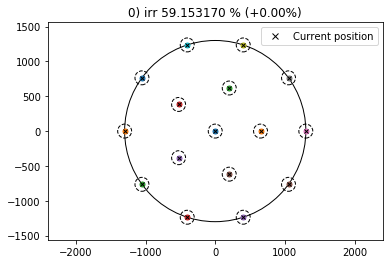

59.15317035889765
59.15317035889765
59.15317035889765
59.15317035889765
59.15317035889765
59.15317035889765
59.15317035889765
59.15317035889765
58.41225917051682
59.15317035889765
58.14510973558744
59.15317035889765
57.694762993654145
59.15317035889765
59.15317035889765
59.15317035889765
59.15317035889765
59.15317035889765
58.982420019807826
59.15317035889765
59.15317035889765
59.15317035889765
59.15317035889765
59.097104702459056
59.15317035889765
59.15317035889765
59.15317035889765
58.415200115067776
59.15317035889765
57.804804947544454
59.15317035889765
59.15317035889765
59.15317035889765
59.13745006160334
59.15317035889765
59.15317035889765
59.22570734248658
59.22570734248658
59.22570734248658
59.22570734248658
59.22570734248658
59.22570734248658
57.21430635638283
59.22570734248658
59.22570734248658
58.873262279585134
59.22570734248658
58.580217389503765
59.22570734248658
59.22570734248658
59.22570734248658
59.22570734248658
59.22570734248658
58.853364402336375
59.22570734248658
59

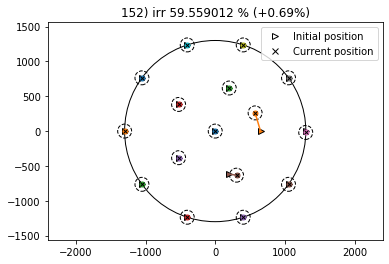

In [5]:
# create an openmdao component for aep and irr to add to the problem
aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func, output_key="aep", output_unit="GWh", objective=False, output_val=np.zeros(n_wt))
irr_comp = CostModelComponent(input_keys=['aep'],   n_wt=n_wt, cost_function=irr_func, output_key="irr", output_unit="%",   objective=True, income_model=True)

# create a group for the aep and irr components that links their common input/output (aep) 
irr_group = TopFarmGroup([aep_comp, irr_comp])

# add the group to an optimization problem and specify the design variables (turbine positions), 
# cost function (irr_group), driver (random search), and constraints (circular boundary and spacing)
problem = TopFarmProblem(
        design_vars=dict(zip('xy', site.initial_position.T)),
        cost_comp=irr_group,
        driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Circle(), max_iter=50),
        #driver=EasyScipyOptimizeDriver(optimizer='COBYLA', maxiter=200, tol=1e-6, disp=False),
        #driver=EasySimpleGADriver(max_gen=100, pop_size=5, Pm=None, Pc=.5, elitism=True, bits={}),
        constraints=[SpacingConstraint(200),
                     CircleBoundaryConstraint([0, 0], 1300.1)],
        plot_comp=plot_comp)

# assign data from optimizationn to a set of accessible variables and run the optimization
cost, state, recorder = problem.optimize()

### Exercise!!

**Play with the driver above to see if an improved objective function can be obtained.**

### DTU Cost Model

The DTU Cost Model is based on more recent industry data. It has a similar structure to the NREL cost and scaling model and contains the major elements to calculate LCOE, IRR etc. One key innovation of the DTU Cost model compared to the NREL cost and scaling model is the use of a detailed financial cash flow analysis. This is not yet implemented but will be implemented in a future version.

For more information on the DTU Cost model see its background here:
https://topfarm.pages.windenergy.dtu.dk/TopFarm2/user_guide.html#dtu-cost-model
and the source code documentation here:
https://topfarm.pages.windenergy.dtu.dk/TopFarm2/api_reference/dtucost.html

**Import the new DTU Cost model**

In [6]:
#import the DTU cost model
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation as ee_2

**Set up the site and inputs as before but with additional cost variables.**

In [11]:
# site set up
n_wt = 16 # number of wind turbines
site = IEA37Site(n_wt) # site is the IEA Wind Task 37 site with a circle boundary
windTurbines = IEA37_WindTurbines() # wind turbines are the IEA Wind Task 37 3.4 MW reference turbine
wake_model = IEA37SimpleBastankhahGaussian(site, windTurbines) # select the Gaussian wake model
AEPCalc = AEPCalculator(wake_model) # set up AEP caculator to use Gaussiann model

# vectors for turbine properties: diameter, rated power and hub height
# these are inputs to the cost model
Drotor_vector = [windTurbines.diameter()] * n_wt 
power_rated_vector = [float(windTurbines.power(20))*1e-6] * n_wt 
hub_height_vector = [windTurbines.hub_height()] * n_wt 

# add additional cost model inputs for shore distance, energy price, project lifetime, rated rotor speed and water depth
distance_from_shore = 30         # [km]
energy_price = 0.1              # [Euro/kWh] What we get per kWh
project_duration = 20            # [years]    
rated_rpm_array = [12] * n_wt    # [rpm]
water_depth_array = [15] * n_wt  # [m]

**Set up the cost function to use the new DTU cost model.**

In [12]:
# set up function for new cost model with initial inputs as set above
eco_eval = ee_2(distance_from_shore, energy_price, project_duration)

# function for calculating aep as a function of x,y positions of the wind turbiens
def aep_func(x, y, **kwargs):
    return AEPCalc.calculate_AEP(x_i=x, y_i=y).sum(-1).sum(-1)*10**6

# function for calculating overall internal rate of return (IRR)
def irr_func(aep, **kwargs):
    eco_eval.calculate_irr(rated_rpm_array, Drotor_vector, power_rated_vector, hub_height_vector, water_depth_array, aep)
    print(eco_eval.IRR)
    return eco_eval.IRR

**Set up rest of problem just as in prior example and run optimization with new model.**

21.446512022323127
21.446512022323127
21.446512022323127
21.407271027231612
21.446512022323127
21.42562808056663
21.446512022323127
21.289671517086006
21.446512022323127
21.28559779300099
21.446512022323127
21.523041851026893
21.523041851026893
21.423994035069892
21.523041851026893
21.523041851026893
21.523041851026893
21.295244735671837
21.523041851026893
21.523041851026893
21.523041851026893
21.523041851026893
21.523041851026893
21.523041851026893
21.523041851026893
21.523041851026893
21.149186574751376
21.523041851026893
21.523041851026893
21.458439229276284
21.523041851026893
21.538505098655737
21.538505098655737
21.538505098655737
21.391488447493966
21.538505098655737
21.538505098655737
21.538505098655737
21.538505098655737
21.538505098655737
21.538505098655737
21.538505098655737
21.538505098655737
21.48326717588771
21.538505098655737
21.538505098655737
21.35263183846805
21.538505098655737
21.538505098655737
21.538505098655737
21.538505098655737
21.53129612159961
21.53850509865573

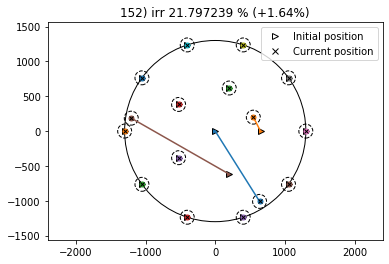

In [13]:
# create an openmdao component for aep and irr to add to the problem
aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func, output_key="aep", output_unit="kWh", objective=False, output_val=np.zeros(n_wt))
irr_comp = CostModelComponent(input_keys=['aep'],   n_wt=n_wt, cost_function=irr_func, output_key="irr", output_unit="%",   objective=True, income_model=True)

# create a group for the aep and irr components that links their common input/output (aep) 
irr_group = TopFarmGroup([aep_comp, irr_comp])

# add the group to an optimization problem and specify the design variables (turbine positions), 
# cost function (irr_group), driver (random search), and constraints (circular boundary and spacing)
problem = TopFarmProblem(
    design_vars=dict(zip('xy', site.initial_position.T)),
    cost_comp=irr_group,
    driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Circle(), max_iter=50),
    constraints=[SpacingConstraint(200),
                 CircleBoundaryConstraint([0, 0], 1300.1)],
    plot_comp=plot_comp)
 
# assign data from optimizationn to a set of accessible variables and run the optimization
cost, state, recorder = problem.optimize()

Note how the IRR results with the new cost model are quite different (lower) than the old NREL cost and scaling model.

### Exercise!!

Manipulate the cost inputs to the DTU cost model to see the impact on IRR.